In [1]:
# imports
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs import ColorBar
import re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.0 Compas

## 1.1 Read in Data

In [2]:
#alpha_lr = pd.read_csv("/content/drive/MyDrive/Project/WB_Output/wandb_compas_LR_alpha_schedule.csv")
alpha_lr = pd.read_csv("/content/drive/MyDrive/Project/WB_Output/wandb_compas_good.csv")
alpha_lr = alpha_lr.rename( columns = {'alpha_0':'alpha_dp', 
                                         'alpha_1':'alpha_eo', 
                                         'train_dpd':'train_demographic_parity',  
                                         'train_edd':'train_equalized_odds',
                                         'val_dpd':'val_demographic_parity_gap',  
                                         'val_edd':'val_equalized_odds_gap', 
                                         'test_dpd':'test_demographic_parity',  
                                         'test_edd':'test_equalized_odds'})

## 1.2 Baseline Model Results

In [3]:
# baseline models
baseline = alpha_lr[(alpha_lr['alpha_dp'] == 0)& (alpha_lr['alpha_eo'] == 0)]
baseline = baseline[['val_accuracy', 'val_demographic_parity_gap','val_equalized_odds_gap']]
baseline

,val_accuracy,val_demographic_parity_gap,val_equalized_odds_gap
99,0.653533,0.129877,0.155741


# 1.3 Accuracy vs. Demographic Parity | Single Regularizer

In [12]:
# train, alpha, figure
train_cols = [  'val_accuracy', ]
alpha = [0, 1, 10,20, 30,40, 50, 100, 150,200] #, 600] #, 1000, 3000, 6000, 12000]
fig_train = go.Figure() #make_subplots(rows=2, cols=3, subplot_titles=("validation alpha_dp = 0", "validation alpha_dp = 1", "validation alpha_dp = 10", "validation alpha_dp = 100",  "validation alpha_dp = 1000")) #, "blank"))

# trace colour
trace_colour = {0 :'#636EFA',
                1: '#EF553B',
                10: '#00CC96',
                100 :'#AB63FA',
                1000:'#FFA15A',
                3000:'#19D3F3',
                6000:'#FF6692',
                12000:  '#B6E880',
                600: '#FF97FF',
                300:'#FECB52'}

# single regularizer 
subset = alpha_lr[alpha_lr["alpha_eo"] ==0]

# store X and Y values for each alpha to plot
Y, X = [], []
for a in alpha:
  new_subset = subset[subset["alpha_dp"] == a]

  for col in train_cols:  
    Y.append((new_subset["val_demographic_parity_gap"].values[0]-baseline["val_demographic_parity_gap"].values[0])/baseline["val_demographic_parity_gap"].values[0])
    X.append((new_subset["val_accuracy"].values[0]-baseline["val_accuracy"].values[0])/baseline["val_accuracy"].values[0])


# plot results
fig_train.add_trace(go.Scatter(y=Y, x=X, mode = 'markers+text', text=alpha, marker=dict(
        
        cmax=np.log(200),
        cmin=1,
        color=np.log(alpha),
       
        colorbar=dict(
            title=r'$\alpha_$', 
            ticktext = alpha, 
            tickvals = np.log(alpha)
        ),
        colorscale="Bluered"
    ),))   #trace_colour[a] ,

# update figure and plot
fig_train.update_xaxes(title_text= "Accuracy Difference from Baseline")
fig_train.update_yaxes(title_text= "Demographic Parity Difference from Baseline")
fig_train.update_traces(textposition='bottom center') #text=alpha,
fig_train['layout'].update(height=400, width=600)
fig_train.update_layout( 
    legend_title_text=r'$\alpha_ \text{values}$',
    title=r"$\text{COMPAS Validation } \alpha_{Equalized Odds} = 0$")
  
fig_train.show()

<ipython-input-12-b1ea3168fffc>:36: RuntimeWarning:

divide by zero encountered in log

<ipython-input-12-b1ea3168fffc>:41: RuntimeWarning:

divide by zero encountered in log



# 1.4 Accuracy vs. Equalized Odds | Single Regularizer

In [11]:
# train, alpha, figure
train_cols = [  'val_accuracy', ] #'val_demographic_parity_gap',  'val_equalized_odds_gap',
alpha =[0, 1, 10,20, 30,40, 50, 100, 150,200] #, 600] #, 1000, 3000, 6000, 12000]
fig_train = go.Figure() #make_subplots(rows=2, cols=3, subplot_titles=("validation alpha_dp = 0", "validation alpha_dp = 1", "validation alpha_dp = 10", "validation alpha_dp = 100",  "validation alpha_dp = 1000")) #, "blank"))

#trace colour
trace_colour = {0 :'#636EFA',
                1: '#EF553B',
                10: '#00CC96',
                100 :'#AB63FA',
                1000:'#FFA15A',
                3000:'#19D3F3',
                6000:'#FF6692',
                12000:  '#B6E880',
                600: '#FF97FF',
                300:'#FECB52'}


# single regularizer 
subset = alpha_lr[alpha_lr["alpha_dp"] ==0]

# store X and Y values for each alpha to plot
Y, X = [], []
for a in alpha:
  new_subset = subset[subset["alpha_eo"] == a]

  for col in train_cols:  
    Y.append((new_subset["val_equalized_odds_gap"].values[0]-baseline["val_equalized_odds_gap"].values[0])/baseline["val_equalized_odds_gap"].values[0])
    X.append((new_subset["val_accuracy"].values[0]-baseline["val_accuracy"].values[0])/baseline["val_accuracy"].values[0])


# plot
fig_train.add_trace(go.Scatter(y=Y, x=X, mode = 'markers+text',  text=alpha, marker=dict(
        
        cmax=np.log(200),
        cmin=1,
        color=np.log(alpha),
       
        colorbar=dict(
            title=r'$\alpha_$', 
            ticktext = alpha, 
            tickvals = np.log(alpha)
        ),
        colorscale="Bluered"
    ),))   #trace_colour[a] ,

# update figure and plot
fig_train.update_xaxes(title_text= "Accuracy Difference from Baseline")
fig_train.update_yaxes(title_text= "Equalized Odds Difference from Baseline")
fig_train.update_traces(textposition='bottom center') 
fig_train['layout'].update(height=400, width=600)
fig_train.update_layout( 
    legend_title_text=r'$\alpha_ \text{values}$',
    title=r"$\text{COMPAS Validation } \alpha_{Demographic Parity} = 0$")

  
fig_train.show()

<ipython-input-11-08d1b8878766>:37: RuntimeWarning:

divide by zero encountered in log

<ipython-input-11-08d1b8878766>:42: RuntimeWarning:

divide by zero encountered in log



# 1.5 Demographic Parity vs. Equalized Odds | Single Regularizer

In [6]:
# train, alpha, figure
train_cols = [  'val_accuracy', ] #'val_demographic_parity_gap',  'val_equalized_odds_gap',
alpha =[0, 1, 10,20, 30,40, 50, 100, 150,200] #, 600] #, 1000, 3000, 6000, 12000]
fig_train = go.Figure() #make_subplots(rows=2, cols=3, subplot_titles=("validation alpha_dp = 0", "validation alpha_dp = 1", "validation alpha_dp = 10", "validation alpha_dp = 100",  "validation alpha_dp = 1000")) #, "blank"))

# trace colour
trace_colour = {0 :'#636EFA',
                1: '#EF553B',
                10: '#00CC96',
                100 :'#AB63FA',
                1000:'#FFA15A',
                3000:'#19D3F3',
                6000:'#FF6692',
                12000:  '#B6E880',
                600: '#FF97FF',
                300:'#FECB52'}

# single regularizer 
subset = alpha_lr[alpha_lr["alpha_dp"] ==0]

# store X and Y values for each alpha to plot
Y, X = [], []
for a in alpha:
  new_subset = subset[subset["alpha_eo"] == a]

  for col in train_cols:  
    Y.append((new_subset["val_equalized_odds_gap"].values[0]-baseline["val_equalized_odds_gap"].values[0])/baseline["val_equalized_odds_gap"].values[0])
    X.append((new_subset["val_demographic_parity_gap"].values[0]-baseline["val_demographic_parity_gap"].values[0])/baseline["val_demographic_parity_gap"].values[0])


# plot
fig_train.add_trace(go.Scatter(y=Y, x=X, mode = 'markers+text',  text=alpha, marker=dict(
        
        cmax=np.log(200),
        cmin=1,
        color=np.log(alpha),
       
        colorbar=dict(
            title=r'$\alpha_$', 
            ticktext = alpha, 
            tickvals = np.log(alpha)
        ),
        colorscale="Bluered"
    ),))   #trace_colour[a] ,

# update figure and plot
fig_train.update_xaxes(title_text= "Demographic Parity Gap")
fig_train.update_yaxes(title_text= "Equalized Odds Gap")
fig_train.update_traces(textposition='bottom center') 
fig_train['layout'].update(height=400, width=600)
fig_train.update_layout( 
    legend_title_text=r'$\alpha_ \text{values}$',
    title=r"$\text{COMPAS Validation } \alpha_{Demographic Parity} = 0$")

  
fig_train.show()

<ipython-input-6-440d078d92c2>:36: RuntimeWarning:

divide by zero encountered in log

<ipython-input-6-440d078d92c2>:41: RuntimeWarning:

divide by zero encountered in log



## 1.6 Heatmaps | Combined Regularizers

### 1.6.1 Prepare Heatmap

In [7]:

heatmap_df = alpha_lr[['alpha_eo', 'alpha_dp','val_accuracy', 'val_demographic_parity_gap','val_equalized_odds_gap']]
heatmap_df['%dpd'] = heatmap_df.val_demographic_parity_gap.apply(lambda x: (x-baseline.val_demographic_parity_gap)/baseline.val_demographic_parity_gap )
heatmap_df['%eod'] = heatmap_df.val_equalized_odds_gap.apply(lambda x: (x-baseline.val_equalized_odds_gap)/baseline.val_equalized_odds_gap )
heatmap_df['%acc'] = heatmap_df.val_accuracy.apply(lambda x: (x-baseline.val_accuracy)/baseline.val_accuracy )
heatmap_df['acc/dpd'] = heatmap_df['%acc']/heatmap_df['%dpd'].fillna(0)
heatmap_df['acc/eod'] = heatmap_df['%acc']/heatmap_df['%eod'].fillna(0)

<ipython-input-7-5d3b159d1a55>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-5d3b159d1a55>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-5d3b159d1a55>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-5d3b159d1a5

### 1.6.2 Heatmap: % Change in Accuracy

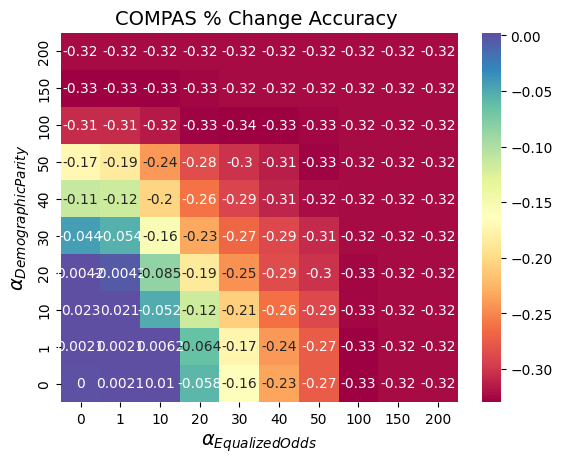

In [8]:
df_dpd_heat_map = heatmap_df.pivot(index='alpha_dp',columns='alpha_eo',values='%acc')
df_dpd_heat_map = df_dpd_heat_map.sort_values(by='alpha_dp',ascending=False)
sns.heatmap(df_dpd_heat_map,vmax = 0.0025, vmin = -0.33,annot=True,cmap="Spectral")
plt.title("COMPAS % Change Accuracy ",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 1.6.3 Heatmap: % Change in Equalized Odds

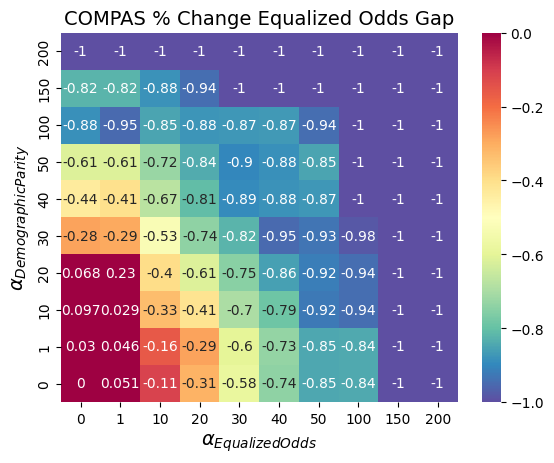

In [9]:
df_eod_heat_map = heatmap_df.pivot(index='alpha_dp',columns='alpha_eo',values='%eod')
df_eod_heat_map = df_eod_heat_map.sort_values(by='alpha_dp',ascending=False)
sns.heatmap(df_eod_heat_map,vmax = 0,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("COMPAS % Change Equalized Odds Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 1.6.4 Heatmap: % Change in Demographic Parity

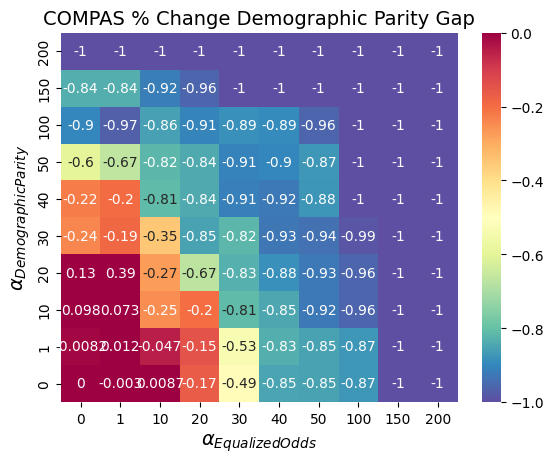

In [10]:
df_eod_heat_map = heatmap_df.pivot(index='alpha_dp',columns='alpha_eo',values='%dpd')
df_eod_heat_map = df_eod_heat_map.sort_values(by='alpha_dp',ascending=False)
sns.heatmap(df_eod_heat_map,vmax = 0,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("COMPAS % Change Demographic Parity Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()